# Homework 1
link: https://piazza.com/class_profile/get_resource/lud4rov7mrp6e7/lujm1nqjf31s7


## Problem 1

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [2]:
n = 100 # timesteps
t0, x0, x_dot0 = 0, 0, 0
tf, xf, x_dotf = 7, 10, 0
dt = (tf - t0) / n

ua_out = cp.Variable(n)
xa_out = cp.Variable(n)
x_dot_ = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(ua_out))
constraints = [xa_out[0] == x0, x_dot_[0] == x_dot0, xa_out[n-1] == xf, x_dot_[n-1] == x_dotf, 
               -1 <= ua_out, ua_out <= 1]
for i in range(1, n):
    constraints += [
        xa_out[i] == xa_out[i-1] + dt * x_dot_[i-1],
        x_dot_[i] == x_dot_[i-1] + dt * ua_out[i-1]
    ]


In [3]:
prob = cp.Problem(objective, constraints)
prob.solve()

52.27526564334637

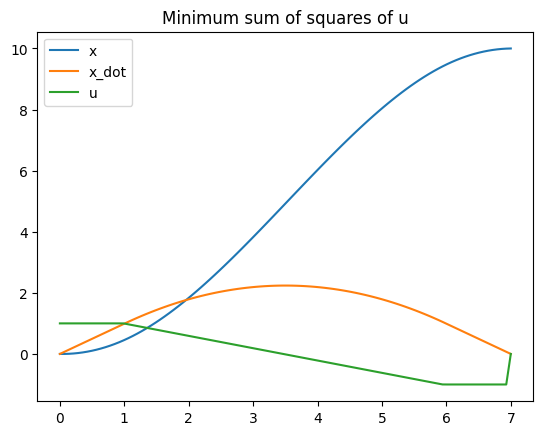

In [4]:
plt.plot(np.linspace(t0, tf, n), xa_out.value, label='x')
plt.plot(np.linspace(t0, tf, n), x_dot_.value, label='x_dot')
plt.plot(np.linspace(t0, tf, n), ua_out.value, label='u')
plt.legend()
plt.title('Minimum sum of squares of u')
plt.show()

In [5]:
objective = cp.Minimize(cp.sum(cp.abs(ua_out)))
prob = cp.Problem(objective, constraints)
prob.solve()

/Users/yefan/opt/miniconda3/envs/cds212/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


58.54081632736316

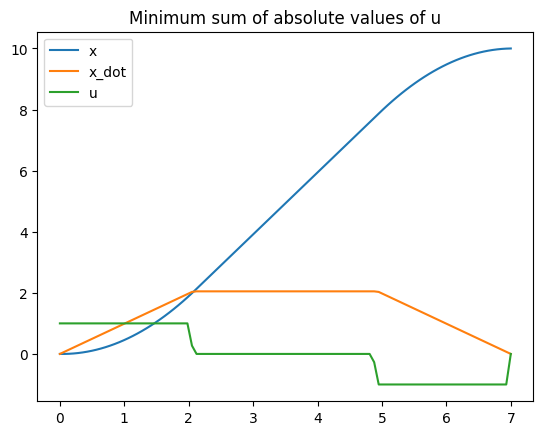

In [6]:
plt.plot(np.linspace(t0, tf, n), xa_out.value, label='x')
plt.plot(np.linspace(t0, tf, n), x_dot_.value, label='x_dot')
plt.plot(np.linspace(t0, tf, n), ua_out.value, label='u')
plt.legend()
plt.title('Minimum sum of absolute values of u')
plt.show()

## Problem 2

In [10]:
n = 100
t0, x0, y0, x_dot0, y_dot0 = 0, 0, 0, 0, 0
tf, xf, yf, x_dotf, y_dotf = 10, 10, 0, 0, 0
x_obs, y_obs, r_obs = 5, 0, 1
min_dist = 0.1
dt = (tf - t0) / n
def problem2_scp_single(nominal_x : np.ndarray, 
                        t0=0, x0=0, y0=0, x_dot0=0, y_dot0=0,
                        tf=10, xf=10, yf=0, x_dotf=0, y_dotf=0,
                        x_obs=5, y_obs=0, r_obs=1, min_dist=0.1, n=100, 
                        obstacle=True
                        ):
    u = cp.Variable((n, 2))
    x = cp.Variable((n, 2))
    x_dot = cp.Variable((n, 2))
    objective = cp.Minimize(cp.sum_squares(u))

    constraints = [
                    x[0] == np.array([x0, y0]), x[n-1] == np.array([xf, yf]),    # initial conditions
                    x_dot[0] == np.array([x_dot0, y_dot0]), x_dot[n-1] == np.array([x_dotf, y_dotf]), # final conditions
                    -1 <= u[:, 0], u[:, 0] <= 1, -1 <= u[:, 1], u[:, 1] <= 1, # input constraints
                ]


    for i in range(1, n):
        constraints += [
            x[i] == x[i-1] + dt * x_dot[i-1],
            x_dot[i] == x_dot[i-1] + dt * u[i-1], 
            # cp.norm(x[i] - np.array([x_obs, y_obs])) >= min_dist  # the full non-convex constraint
            ((nominal_x[i] - np.array([x_obs, y_obs])) @ (x[i] - np.array([x_obs, y_obs]))) >= (r_obs + min_dist) * cp.norm(nominal_x[i] - np.array([x_obs, y_obs])),
        ]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    # print(prob.status)
    return x, x_dot, u, prob.value, prob.status

In [11]:
epsilon = 0.1
nominal_xa = np.concatenate((np.linspace(np.array([x0, y0]), np.array([5, 5]), n//2), np.linspace(np.array([5, 5]), np.array([xf, yf]), n//2)), axis=0)
# nominal_x = np.linspace(np.array([x0, y0]), np.array([xf, yf]), n)
i = 0

while True:
    xa_out, x_dot_, ua_out, cost, status = problem2_scp_single(nominal_xa)
    print(f'{i}: {status} : {np.sum(np.square(xa_out.value - nominal_xa))}')
    if np.sum(np.square(xa_out.value - nominal_xa)) < epsilon:
        break
    nominal_xa = xa_out.value
    i += 1


/Users/yefan/opt/miniconda3/envs/cds212/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


0: optimal : 551.7679436802314
1: optimal : 0.004194438377907222


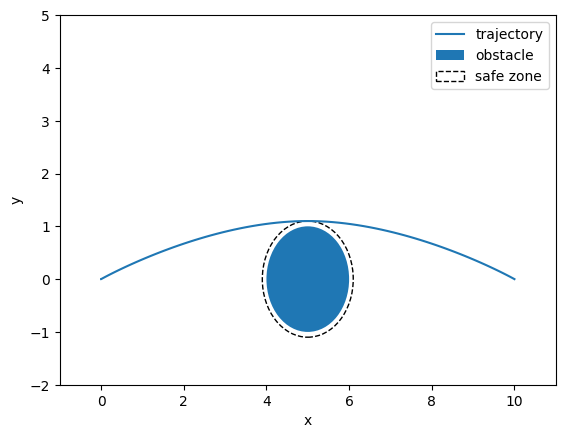

In [12]:
plt.plot(xa_out.value[:, 0], xa_out.value[:, 1], label='trajectory')
circle1 = plt.Circle((x_obs, y_obs), r_obs, fill=True, label='obstacle')
circle2 = plt.Circle((x_obs, y_obs), r_obs + min_dist, fill=False, label='safe zone', linestyle='--')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 11)
plt.ylim(-2, 5)
plt.legend()

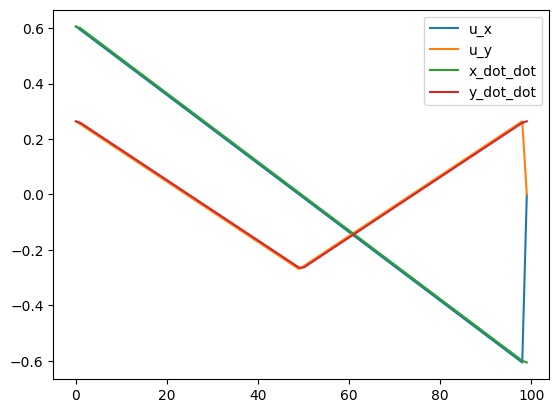

In [13]:
plt.plot(ua_out.value[:, 0], label='u_x')
plt.plot(ua_out.value[:, 1], label='u_y')
plt.plot(np.gradient(x_dot_.value[:, 0], dt), label='x_dot_dot')
plt.plot(np.gradient(x_dot_.value[:, 1], dt), label='y_dot_dot')
plt.legend()
problem2_x = xa_out.value[:, :2]

## Problem 3


In [14]:
n = 100
t0, x0, y0, x_dot0, y_dot0 = 0, 0, 0, 0, 0
tf, xf, yf, x_dotf, y_dotf = 10, 10, 0, 0, 0
x_obs, y_obs, r_obs = 5, 0, 1
min_dist = 0.1
dt = (tf - t0) / n

def problem3_scp_single(nominal_x : np.ndarray, nominal_u : np.ndarray, trust_region=10, 
                        t0=0, x0=0, y0=0, x_dot0=0, y_dot0=0,
                        tf=10, xf=10, yf=0, x_dotf=0, y_dotf=0,
                        x_obs=5, y_obs=0, r_obs=1, min_dist=0.1, n=100, obstacle=True):
    assert nominal_x.shape == (n, 6)
    assert nominal_u.shape == (n, 2)
    u = cp.Variable((n, 2))
    x = cp.Variable((n, 6))
    objective = cp.Minimize(cp.sum_squares(u))

    constraints = [
                    x[0, :2] == np.array([x0, y0]), x[n-1, :2] == np.array([xf, yf]),    # initial conditions
                    x[0, 3:5] == np.array([x_dot0, y_dot0]), 
                    x[n-1, 3:5] == np.array([x_dotf, y_dotf]), # final conditions
                    0 <= u[:, 0], u[:, 0] <= 1, 
                    -10 <= u[:, 1], u[:, 1] <= 10, # input constraints
                ]


    for i in range(1, n):
        u_ = nominal_u[i-1, 0]
        theta_ = nominal_x[i-1, 2]
        
        constraints += [
            x[i, :3] == x[i-1, :3] + dt * x[i-1, 3:6],
            x[i, 3] == x[i-1, 3] + dt * (u[i-1,0]*np.cos(theta_) - u_*np.sin(theta_)*(x[i-1,2]-theta_)),
            x[i, 4] == x[i-1, 4] + dt * (u[i-1,0]*np.sin(theta_) + u_*np.cos(theta_)*(x[i-1,2]-theta_)),
            # cp.abs(x[i-1, 2] - theta_) <= trust_region,
            x[i, 5] == x[i-1, 5] + dt * u[i-1, 1],
            # cp.norm(x[i] - np.array([x_obs, y_obs])) >= min_dist  # the full non-convex constraint
            # ((nominal_x[i, :2] - np.array([x_obs, y_obs])) @ (x[i, :2] - np.array([x_obs, y_obs]))) >= (r_obs + min_dist) * cp.norm(nominal_x[i, :2] - np.array([x_obs, y_obs])),
        ]

        if obstacle:
            constraints += [
                ((nominal_x[i, :2] - np.array([x_obs, y_obs])) @ (x[i, :2] - np.array([x_obs, y_obs]))) >= (r_obs + min_dist) * cp.norm(nominal_x[i, :2] - np.array([x_obs, y_obs])),
            ]
        
        if trust_region > 0:
            constraints += [
                cp.abs(x[i, 2] - theta_) <= trust_region
            ]

    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=False)
    print(prob.status)
    return x, x_dot_, u, prob.value, prob.status

epsilon = 0.1
nominal_xa = np.zeros((n, 6))
nominal_ua = np.zeros((n, 2))
nominal_xa[:, :2] = problem2_x
nominal_xa[:, 3] = np.gradient(nominal_xa[:, 0], dt)
nominal_xa[:, 4] = np.gradient(nominal_xa[:, 1], dt)
nominal_xa[:, 5] = np.gradient(nominal_xa[:, 2], dt)
x_dot_dot = np.gradient(nominal_xa[:, 3], dt)
y_dot_dot = np.gradient(nominal_xa[:, 4], dt)
nominal_xa[:, 2] = np.arctan(y_dot_dot / x_dot_dot)
nominal_ua[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)
i = 0

# plt.plot(nominal_xa[:, 0], nominal_xa[:, 1], label='nominal trajectory')
# plt.plot(nominal_xa[:, 0], nominal_xa[:, 2], label='nominal theta')
# plt.plot(nominal_xa[:, 0], nominal_ua[:, 0], label='nominal u1')
# # plt.plot(nominal_x[:, 0], nominal_x[:, 4], label='nominal y_dot')
# plt.legend()

print(nominal_xa.shape, nominal_ua.shape)
xa_out, x_dot_, ua_out, cost, status = problem3_scp_single(nominal_xa, nominal_ua)

(100, 6) (100, 2)
optimal


In [15]:
nominal_xa = np.zeros((n, 6))
nominal_ua = np.zeros((n, 2))
nominal_xa[:, :2] = problem2_x
nominal_xa[:, 3] = np.gradient(nominal_xa[:, 0], dt)
nominal_xa[:, 4] = np.gradient(nominal_xa[:, 1], dt)
nominal_xa[:, 5] = np.gradient(nominal_xa[:, 2], dt)
x_dot_dot = np.gradient(nominal_xa[:, 3], dt)
y_dot_dot = np.gradient(nominal_xa[:, 4], dt)
nominal_xa[:, 2] = np.arctan2(y_dot_dot, x_dot_dot)
nominal_ua[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)
i = 0
epsilon = 0.3

print(nominal_xa.shape, nominal_ua.shape)
trust_region = 10
decay = 0.9

while True:
    xa_out, x_dot_, ua_out, cost, status = problem3_scp_single(nominal_xa, nominal_ua, trust_region=trust_region)
    if (status != cp.OPTIMAL) and (status != cp.OPTIMAL_INACCURATE):
        print(f'{i}: {status}')
        break
    # print(x_.shape, nominal_x.shape)
    print(f'{i}: {status} : {np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2]))}')
    if np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2])) < epsilon:
        break
    # break
    nominal_xa = xa_out.value[:, :]
    nominal_ua = ua_out.value[:, :]
    i += 1
    trust_region *= decay


(100, 6) (100, 2)
optimal
0: optimal : 37.710104076151076
optimal
1: optimal : 17.53717393401109
optimal
2: optimal : 17.251134416139102
optimal
3: optimal : 165.1449560997103
optimal
4: optimal : 94.55738419187684
optimal
5: optimal : 59.802094576139815
optimal
6: optimal : 29.251342792973553
optimal
7: optimal : 51.42959123315763
optimal
8: optimal : 16.44291751727158
optimal
9: optimal : 19.444541893272955
optimal
10: optimal : 35.91332323271533
optimal
11: optimal : 15.912834753567246
optimal
12: optimal : 25.209767599148357
optimal
13: optimal : 7.321840677984416
optimal
14: optimal : 7.046306976120826
optimal
15: optimal : 7.851772052364962
optimal
16: optimal : 3.885632045592447
optimal
17: optimal : 2.568491933803797
optimal
18: optimal : 3.754915910023677
optimal
19: optimal : 3.464321880644711
optimal
20: optimal : 4.071189810327192
optimal
21: optimal : 3.888061522610993
optimal
22: optimal : 3.503358538457433
optimal
23: optimal : 3.2504027939768183
optimal
24: optimal : 2.

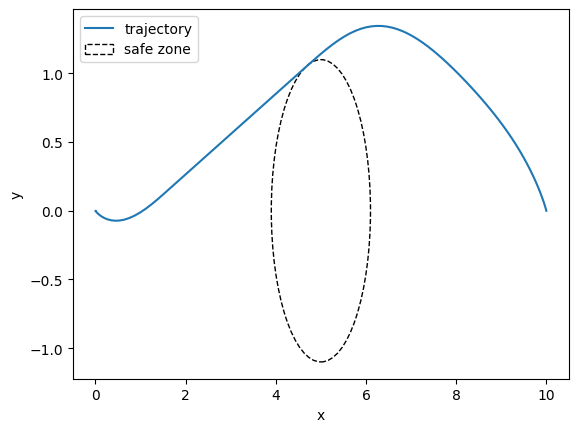

In [16]:
plt.plot(xa_out.value[:, 0], xa_out.value[:, 1], label='trajectory')
circle1 = plt.Circle((x_obs, y_obs), r_obs, fill=True, label='obstacle')
circle2 = plt.Circle((x_obs, y_obs), r_obs + min_dist, fill=False, label='safe zone', linestyle='--')
# plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-1, 11)
# plt.ylim(-2, 5)
plt.legend()

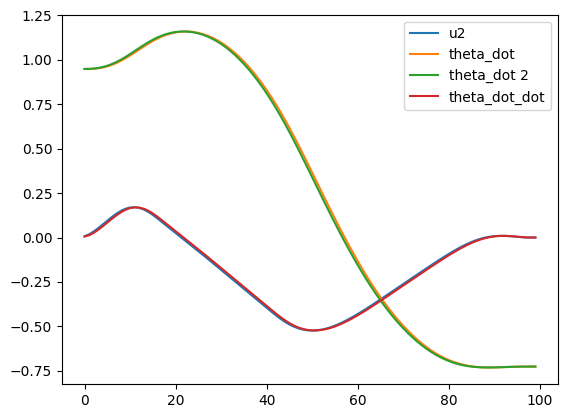

In [17]:
# plt.plot(x_.value[:, 2], label='theta')
# plt.plot(u.value[:, 0], label='u1')
plt.plot(ua_out.value[:, 1], label='u2')
plt.plot(np.gradient(xa_out.value[:, 2], dt), label='theta_dot')
plt.plot(xa_out.value[:, 5], label='theta_dot 2')
plt.plot(np.gradient(xa_out.value[:, 5], dt), label='theta_dot_dot')
plt.legend()

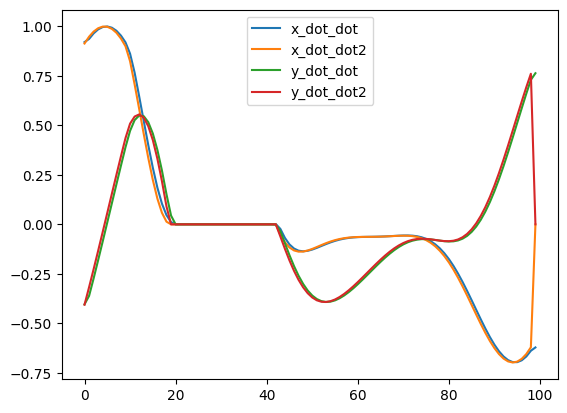

In [18]:
# plt.plot(x_.value[:, 2], label='theta')
plt.plot(np.gradient(xa_out.value[:, 3], dt), label='x_dot_dot')
plt.plot(np.cos(xa_out.value[:, 2]) * ua_out.value[:, 0], label='x_dot_dot2')
# (u[i-1,0]*np.cos(theta_) - u_*np.sin(theta_)*(x[i-1,2]-theta_))
# plt.plot(u.value[:, 0] * np.cos(nominal_x[:, 2]) - nominal_u[:, 0] * np.sin(nominal_x[:, 2])*(x_.value[:, 2] - nominal_x[:, 2]), label='x_dot_dot3')
plt.plot(np.gradient(xa_out.value[:, 4], dt), label='y_dot_dot')
plt.plot(np.sin(xa_out.value[:, 2]) * ua_out.value[:, 0], label='y_dot_dot2')
# plt.plot(u.value[:, 1], label='u2')
# plt.plot(np.gradient(x_.value[:, 2], dt), label='theta_dot')
# plt.plot(x_.value[:, 5], label='theta_dot 2')
# plt.plot(np.gradient(x_.value[:, 5], dt), label='theta_dot_dot')
plt.legend()

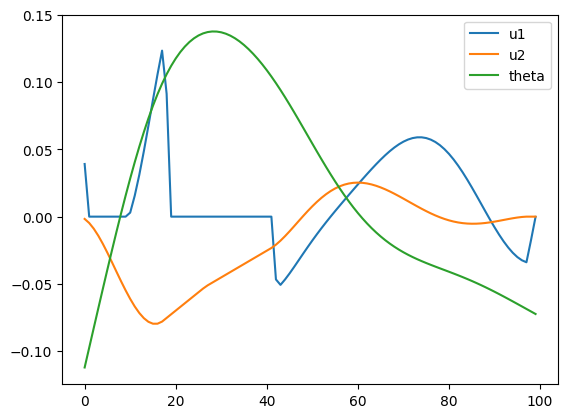

In [19]:
plt.plot(ua_out.value[:, 0] - nominal_ua[:, 0], label='u1')
plt.plot(ua_out.value[:, 1] - nominal_ua[:, 1], label='u2')
plt.plot(xa_out.value[:, 2] - nominal_xa[:, 2], label='theta')
plt.legend()

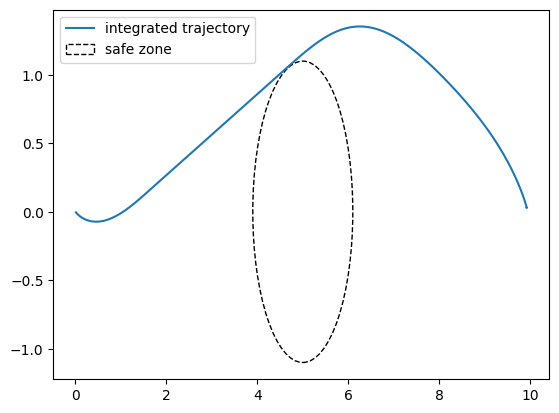

In [20]:
integrated_theta = np.cumsum(np.cumsum(ua_out.value[:, 1]) * dt + xa_out.value[0, 5]) * dt + xa_out.value[0, 2]
integrated_x = np.cumsum(np.cumsum(np.cos(xa_out.value[:, 2]) * ua_out.value[:, 0]) * dt + xa_out.value[0, 3]) * dt + xa_out.value[0, 0]
integrated_y = np.cumsum(np.cumsum(np.sin(xa_out.value[:, 2]) * ua_out.value[:, 0]) * dt + xa_out.value[0, 4]) * dt + xa_out.value[0, 1]

# plt.plot(integrated_theta, label='integrated theta')
# plt.plot(x_.value[:, 2], label='theta')
plt.plot(integrated_x, integrated_y, label='integrated trajectory')
circle1 = plt.Circle((x_obs, y_obs), r_obs, fill=True, label='obstacle')
circle2 = plt.Circle((x_obs, y_obs), r_obs + min_dist, fill=False, label='safe zone', linestyle='--')
# plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.legend()

In [ ]:
problem3_x = xa_out.value

# Problem 4

In [21]:
nominal_xa = np.concatenate((np.linspace(np.array([x0, y0]), np.array([5, 5]), n//2), np.linspace(np.array([5, 5]), np.array([xf, yf]), n//2)), axis=0)

print(nominal_xa.shape, nominal_ua.shape)
trust_region = 10
decay = 0.9
i = 0
epsilon = 0.3

while True:
    xa_out, x_dot_, ua_out, cost, status = problem2_scp_single(nominal_xa, obstacle=False)
    if (status != cp.OPTIMAL) and (status != cp.OPTIMAL_INACCURATE):
        print(f'{i}: {status}')
        break
    # print(x_.shape, nominal_x.shape)
    print(f'{i}: {status} : {np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2]))}')
    if np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2])) < epsilon:
        break
    # break
    nominal_xa = xa_out.value[:, :]
    nominal_ua = ua_out.value[:, :]
    i += 1

problem2_out = xa_out.value

nominal_xa = np.zeros((n, 6))
nominal_ua = np.zeros((n, 2))
nominal_xa[:, :2] = problem2_out
nominal_xa[:, 3] = np.gradient(nominal_xa[:, 0], dt)
nominal_xa[:, 4] = np.gradient(nominal_xa[:, 1], dt)
nominal_xa[:, 5] = np.gradient(nominal_xa[:, 2], dt)
x_dot_dot = np.gradient(nominal_xa[:, 3], dt)
y_dot_dot = np.gradient(nominal_xa[:, 4], dt)
nominal_xa[:, 2] = np.arctan2(y_dot_dot, x_dot_dot)
nominal_ua[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)
i = 0
epsilon = 0.3

while True:
    xa_out, x_dot_, ua_out, cost, status = problem3_scp_single(nominal_xa, nominal_ua, obstacle=False, trust_region=trust_region)
    if (status != cp.OPTIMAL) and (status != cp.OPTIMAL_INACCURATE):
        print(f'{i}: {status}')
        break
    # print(x_.shape, nominal_x.shape)
    print(f'{i}: {status} : {np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2]))}')
    if np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2])) < epsilon:
        break
    # break
    nominal_xa = xa_out.value[:, :]
    nominal_ua = ua_out.value[:, :]
    i += 1
    trust_region *= decay

(100, 2) (100, 2)
0: optimal : 551.7679436802314
1: optimal : 0.004194438377907222
optimal
0: optimal : 62.95575425783703
optimal
1: optimal : 272.311265142238
optimal
2: optimal : 35.91162258597298
optimal
3: optimal : 5.5971140377655555
optimal
4: optimal : 8.467574628900417
optimal
5: optimal : 7.624357609395385
optimal
6: optimal : 7.559118883383279
optimal
7: optimal : 10.471055075831948
optimal
8: optimal : 12.275153089034477
optimal
9: optimal : 12.67679934534013
optimal
10: optimal : 12.64689484398885
optimal
11: optimal : 12.358894221136318
optimal
12: optimal : 12.194419118210028
optimal
13: optimal : 12.257734927298634
optimal
14: optimal : 12.275977883207812
optimal
15: optimal : 12.275236601363934
optimal
16: optimal : 12.299384763398384
optimal
17: optimal : 9.694224655204764
optimal
18: optimal : 8.394263639479227
optimal
19: optimal : 5.416059779037404
optimal
20: optimal : 4.571126214325899
optimal
21: optimal : 3.435000240397045
optimal
22: optimal : 3.040528065053318

In [22]:
robota_x = xa_out.value
robota_u = ua_out.value

(100, 2) (100, 2)
0: optimal : 551.7679435883457


/Users/yefan/opt/miniconda3/envs/cds212/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


1: optimal : 0.004194439859601942
optimal
0: optimal : 66.34274390873293
optimal
1: optimal : 274.31691670030955
optimal
2: optimal : 39.723472500797115
optimal
3: optimal : 9.015001658596177
optimal
4: optimal : 7.628571977698538
optimal
5: optimal : 10.910155851941372
optimal
6: optimal : 8.049864188456802
optimal
7: optimal : 10.948482931272618
optimal
8: optimal : 12.56588701711912
optimal
9: optimal : 12.325070802410668
optimal
10: optimal : 12.537390597170976
optimal
11: optimal : 12.456178172617115
optimal
12: optimal : 12.156835951833699
optimal
13: optimal : 12.266484662526265
optimal
14: optimal : 12.309472720773961
optimal
15: optimal : 12.255602575493981
optimal
16: optimal : 11.779448922750005
optimal
17: optimal : 10.641301526252677
optimal
18: optimal : 7.438988601557496
optimal
19: optimal : 6.1617312790698335
optimal
20: optimal : 4.085716807732602
optimal
21: optimal : 3.808470123709385
optimal
22: optimal : 3.172809117434017
optimal
23: optimal : 2.894908672090579
op

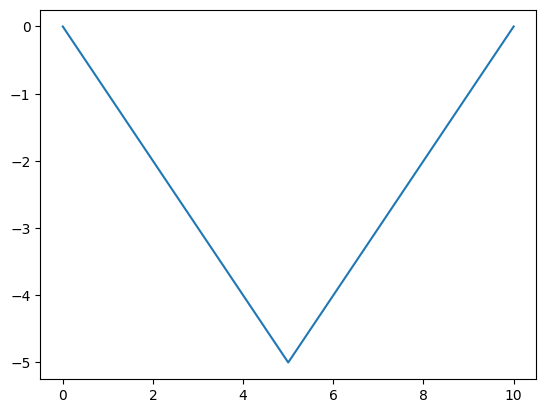

In [29]:
nominal_xa = np.concatenate((np.linspace(np.array([xf, yf]), np.array([5, -5]), n//2), np.linspace(np.array([5, -5]), np.array([x0, x0]), n//2)), axis=0)
plt.plot(nominal_xa[:, 0], nominal_xa[:, 1], label='nominal trajectory')
print(nominal_xa.shape, nominal_ua.shape)
trust_region = 10
decay = 0.9
i = 0
epsilon = 0.3

while True:
    xa_out, x_dot_, ua_out, cost, status = problem2_scp_single(nominal_xa, obstacle=False, x0=xf, y0=yf, x_dot0=x_dotf, y_dot0=y_dotf, xf=x0, yf=y0, x_dotf=x_dot0, y_dotf=y_dot0)
    if (status != cp.OPTIMAL) and (status != cp.OPTIMAL_INACCURATE):
        print(f'{i}: {status}')
        break
    # print(x_.shape, nominal_x.shape)
    print(f'{i}: {status} : {np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2]))}')
    if np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2])) < epsilon:
        break
    # break
    nominal_xa = xa_out.value[:, :]
    nominal_ua = ua_out.value[:, :]
    i += 1

problem2_out = xa_out.value

nominal_xa = np.zeros((n, 6))
nominal_ua = np.zeros((n, 2))
nominal_xa[:, :2] = problem2_out
nominal_xa[:, 3] = np.gradient(nominal_xa[:, 0], dt)
nominal_xa[:, 4] = np.gradient(nominal_xa[:, 1], dt)
nominal_xa[:, 5] = np.gradient(nominal_xa[:, 2], dt)
x_dot_dot = np.gradient(nominal_xa[:, 3], dt)
y_dot_dot = np.gradient(nominal_xa[:, 4], dt)
nominal_xa[:, 2] = np.arctan2(y_dot_dot, x_dot_dot)
nominal_ua[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)
i = 0
epsilon = 0.3

while True:
    xa_out, x_dot_, ua_out, cost, status = problem3_scp_single(nominal_xa, nominal_ua, obstacle=False, trust_region=trust_region,
                                                                x0=xf, y0=yf, x_dot0=x_dotf, y_dot0=y_dotf, xf=x0, yf=y0, x_dotf=x_dot0, y_dotf=y_dot0)
    if (status != cp.OPTIMAL) and (status != cp.OPTIMAL_INACCURATE):
        print(f'{i}: {status}')
        break
    # print(x_.shape, nominal_x.shape)
    print(f'{i}: {status} : {np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2]))}')
    if np.sum(np.square(xa_out.value[:, :2] - nominal_xa[:, :2])) < epsilon:
        break
    # break
    nominal_xa = xa_out.value[:, :]
    nominal_ua = ua_out.value[:, :]
    i += 1
    trust_region *= decay

In [30]:
robotb_x = xa_out.value
robotb_u = ua_out.value

(100, 6) (100, 2)


/Users/yefan/opt/miniconda3/envs/cds212/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


optimal


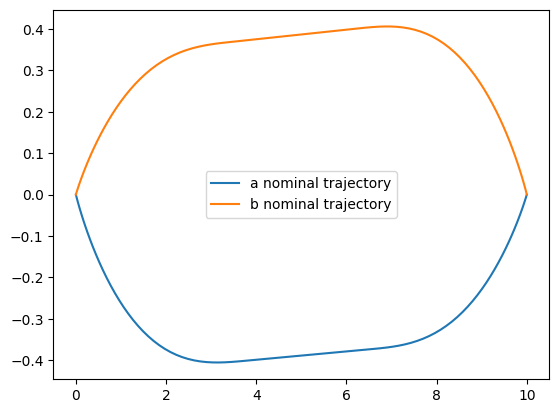

In [36]:
n = 100
t0, xa0, ya0, xb0, yb0, x_dot0, y_dot0 = 0, 0, 0, 10, 0, 0, 0
tf, xaf, yaf, xbf, ybf, x_dotf, y_dotf = 10, 10, 0, 0, 0, 0, 0
min_dist = 1.1
dt = (tf - t0) / n

def problem4_scp_single(nominal_xa : np.ndarray, nominal_ua : np.ndarray, nominal_xb : np.ndarray, nominal_ub : np.ndarray, trust_region=10, obstacle=True):
    assert nominal_xa.shape == (n, 6)
    assert nominal_ua.shape == (n, 2)
    assert nominal_xb.shape == (n, 6)
    assert nominal_ub.shape == (n, 2)
    ua = cp.Variable((n, 2))
    xa = cp.Variable((n, 6))
    ub = cp.Variable((n, 2))
    xb = cp.Variable((n, 6))
    # objective = cp.Minimize(cp.sum_squares(ua) + cp.sum_squares(ub))
    objective = cp.Minimize(cp.sum(cp.abs(ua)) + cp.sum(cp.abs(ub)))

    constraints = [
                    xa[0, :2] == np.array([xa0, ya0]), xa[n-1, :2] == np.array([xaf, yaf]),    # initial conditions
                    xa[0, 3:5] == np.array([x_dot0, y_dot0]), 
                    xa[n-1, 3:5] == np.array([x_dotf, y_dotf]), # final conditions
                    0 <= ua[:, 0], ua[:, 0] <= 1, 
                    -10 <= ua[:, 1], ua[:, 1] <= 10, # input constraints

                    xb[0, :2] == np.array([xb0, yb0]), xb[n-1, :2] == np.array([xbf, ybf]),    # initial conditions
                    xb[0, 3:5] == np.array([x_dot0, y_dot0]), 
                    xb[n-1, 3:5] == np.array([x_dotf, y_dotf]), # final conditions
                    0 <= ub[:, 0], ub[:, 0] <= 1, 
                    -10 <= ub[:, 1], ub[:, 1] <= 10, # input constraints
                ]

    for i in range(1, n):
        ua_ = nominal_ua[i-1, 0]
        thetaa_ = nominal_xa[i-1, 2]
        
        constraints += [
            xa[i, :3] == xa[i-1, :3] + dt * xa[i-1, 3:6],
            xa[i, 3] == xa[i-1, 3] + dt * (ua[i-1,0]*np.cos(thetaa_) - ua_*np.sin(thetaa_)*(xa[i-1,2]-thetaa_)),
            xa[i, 4] == xa[i-1, 4] + dt * (ua[i-1,0]*np.sin(thetaa_) + ua_*np.cos(thetaa_)*(xa[i-1,2]-thetaa_)),
            # cp.abs(xa[i-1, 2] - thetaa_) <= trust_region,
            xa[i, 5] == xa[i-1, 5] + dt * ua[i-1, 1],
            # ((nominal_xa[i, :2] - nominal_xb[i, :2]) @ (xa[i, :2] - nominal_xb[i, :2])) >= min_dist * cp.norm(nominal_xa[i, :2] - nominal_xb[i, :2]),
        ]

        ub_ = nominal_ub[i-1, 0]
        thetab_ = nominal_xb[i-1, 2]

        constraints += [
            xb[i, :3] == xb[i-1, :3] + dt * xb[i-1, 3:6],
            xb[i, 3] == xb[i-1, 3] + dt * (ub[i-1,0]*np.cos(thetab_) - ub_*np.sin(thetab_)*(xb[i-1,2]-thetab_)),
            xb[i, 4] == xb[i-1, 4] + dt * (ub[i-1,0]*np.sin(thetab_) + ub_*np.cos(thetab_)*(xb[i-1,2]-thetab_)),
            # cp.abs(xb[i-1, 2] - thetab_) <= trust_region,
            xb[i, 5] == xb[i-1, 5] + dt * ub[i-1, 1],
            # ((nominal_xb[i, :2] - nominal_xa[i, :2]) @ (xb[i, :2] - nominal_xa[i, :2])) >= min_dist * cp.norm(nominal_xb[i, :2] - nominal_xa[i, :2]),
        ]

        if obstacle:
            constraints += [
                ((nominal_xa[i, :2] - nominal_xb[i, :2]) @ (xa[i, :2] - nominal_xb[i, :2])) >= min_dist * cp.norm(nominal_xa[i, :2] - nominal_xb[i, :2]),
                ((nominal_xb[i, :2] - nominal_xa[i, :2]) @ (xb[i, :2] - nominal_xa[i, :2])) >= min_dist * cp.norm(nominal_xb[i, :2] - nominal_xa[i, :2]),
            ]
        
        if trust_region > 0:
            constraints += [
                cp.abs(xa[i, 2] - thetaa_) <= trust_region,
                cp.abs(xb[i, 2] - thetab_) <= trust_region,
            ]
    prob = cp.Problem(objective, constraints)
    # prob.solve(solver='ECOS', abstol=1e-6)
    prob.solve()
    print(prob.status)
    return xa, ua, xb, ub, prob.value, prob.status

# nominal_xa = np.zeros((n, 6))
# nominal_ua = np.zeros((n, 2))
# nominal_xa[:, 0] = problem3_x[:, 0]
# nominal_xa[:, 1] = problem3_x[:, 1]
# nominal_xa[:, 3] = np.gradient(nominal_xa[:, 0], dt)
# nominal_xa[:, 4] = np.gradient(nominal_xa[:, 1], dt)
# nominal_xa[:, 5] = np.gradient(nominal_xa[:, 2], dt)
# x_dot_dot = np.gradient(nominal_xa[:, 3], dt)
# y_dot_dot = np.gradient(nominal_xa[:, 4], dt)
# nominal_xa[:, 2] = np.arctan2(y_dot_dot, x_dot_dot)
# nominal_ua[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)

# nominal_xb = np.zeros((n, 6))
# nominal_ub = np.zeros((n, 2))
# nominal_xb[:, 0] = problem3_x[:, 0][::-1]
# nominal_xb[:, 1] = -problem3_x[:, 1]
# nominal_xb[:, 3] = np.gradient(nominal_xb[:, 0], dt)
# nominal_xb[:, 4] = np.gradient(nominal_xb[:, 1], dt)
# nominal_xb[:, 5] = np.gradient(nominal_xb[:, 2], dt)
# x_dot_dot = np.gradient(nominal_xb[:, 3], dt)
# y_dot_dot = np.gradient(nominal_xb[:, 4], dt)
# nominal_xb[:, 2] = np.arctan2(y_dot_dot, x_dot_dot)
# nominal_ub[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)

nominal_xa = robota_x
nominal_ua = robota_u
nominal_xb = robotb_x
nominal_ub = robotb_u
i = 0

plt.plot(nominal_xa[:, 0], nominal_xa[:, 1], '-', label='a nominal trajectory')
# angles = np.arctan2(np.gradient(nominal_xa[:, 1]), np.gradient(nominal_xa[:, 0]))
# plt.quiver(nominal_xa[:, 0], nominal_xa[:, 1], np.sin(angles), np.cos(angles), label='a nominal direction')
# plt.plot(nominal_xa[:, 0], nominal_xa[:, 2], label='a nominal theta')
# plt.plot(nominal_xa[:, 0], nominal_ua[:, 0], label='a nominal u1')
plt.plot(nominal_xb[:, 0], nominal_xb[:, 1], '-', label='b nominal trajectory')
# plt.quiver(nominal_xb[:, 0], nominal_xb[:, 1], np.gradient(nominal_xb[:, 0], dt), np.gradient(nominal_xb[:, 1], dt), label='b nominal direction')
# plt.plot(nominal_xb[:, 0], nominal_xb[:, 2], label='b nominal theta')
# plt.plot(nominal_xb[:, 0], nominal_ub[:, 0], label='b nominal u1')
plt.legend()
# print(np.gradient(nominal_xa[:, 0]))
# print(np.gradient(nominal_xb[:, 0]))

print(nominal_xa.shape, nominal_ua.shape)
xa_out, ua_out, xb_out, ub_out, cost, status = problem4_scp_single(nominal_xa, nominal_ua, nominal_xb, nominal_ub, trust_region=100)

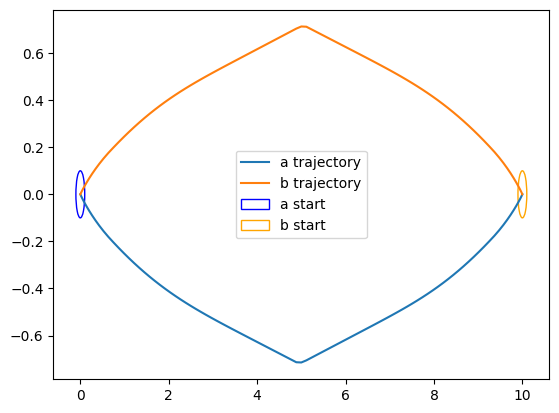

In [33]:
plt.plot(xa_out.value[:, 0], xa_out.value[:, 1], label='a trajectory')
plt.plot(xb_out.value[:, 0], xb_out.value[:, 1], label='b trajectory')
plt.gca().add_patch(plt.Circle(xa_out.value[0, :2], 0.1, fill=False, label='a start', color='blue'))
plt.gca().add_patch(plt.Circle(xb_out.value[0, :2], 0.1, fill=False, label='b start', color='orange'))
plt.legend()

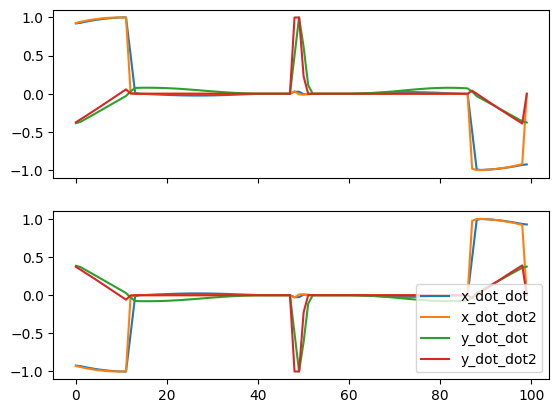

In [34]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(np.gradient(xa_out.value[:, 3], dt), label='x_dot_dot')
ax[0].plot(np.cos(xa_out.value[:, 2]) * ua_out.value[:, 0], label='x_dot_dot2')
ax[0].plot(np.gradient(xa_out.value[:, 4], dt), label='y_dot_dot')
ax[0].plot(np.sin(xa_out.value[:, 2]) * ua_out.value[:, 0], label='y_dot_dot2')
ax[1].plot(np.gradient(xb_out.value[:, 3], dt), label='x_dot_dot')
ax[1].plot(np.cos(xb_out.value[:, 2]) * ub_out.value[:, 0], label='x_dot_dot2')
ax[1].plot(np.gradient(xb_out.value[:, 4], dt), label='y_dot_dot')
ax[1].plot(np.sin(xb_out.value[:, 2]) * ub_out.value[:, 0], label='y_dot_dot2')
plt.legend()

In [42]:
i = 0
epsilon = 5
# nominal_xa = np.zeros((n, 6))
# nominal_ua = np.zeros((n, 2))
# nominal_xa[:, 0] = (problem3_x[:, 0] - 5)
# nominal_xa[:, 1] = problem3_x[:, 1]
# nominal_xa[:, 3] = np.gradient(nominal_xa[:, 0], dt)
# nominal_xa[:, 4] = np.gradient(nominal_xa[:, 1], dt)
# nominal_xa[:, 5] = np.gradient(nominal_xa[:, 2], dt)
# x_dot_dot = np.gradient(nominal_xa[:, 3], dt)
# y_dot_dot = np.gradient(nominal_xa[:, 4], dt)
# nominal_xa[:, 2] = np.arctan2(y_dot_dot, x_dot_dot)
# nominal_ua[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)

# nominal_xb = np.zeros((n, 6))
# nominal_ub = np.zeros((n, 2))
# nominal_xb[:, 0] = -((problem3_x[:, 0] - 5))
# nominal_xb[:, 1] = -problem3_x[:, 1]
# nominal_xb[:, 3] = np.gradient(nominal_xb[:, 0], dt)
# nominal_xb[:, 4] = np.gradient(nominal_xb[:, 1], dt)
# nominal_xb[:, 5] = np.gradient(nominal_xb[:, 2], dt)
# x_dot_dot = np.gradient(nominal_xb[:, 3], dt)
# y_dot_dot = np.gradient(nominal_xb[:, 4], dt)
# nominal_xb[:, 2] = np.arctan2(y_dot_dot, x_dot_dot)
# nominal_ub[:, 0] = np.sqrt(x_dot_dot**2 + y_dot_dot**2)

print(nominal_xa.shape, nominal_ua.shape)
trust_region = 5
decay = 0.6

while True:
    temp_xa_out, temp_ua_out, temp_xb_out, temp_ub_out, cost, status = problem4_scp_single(nominal_xa, nominal_ua, nominal_xb, nominal_ub, trust_region=trust_region)
    if (status != cp.OPTIMAL) and (status != cp.OPTIMAL_INACCURATE):
        print(f'{i}: {status}')
        break
    # print(x_.shape, nominal_x.shape)
    diference = np.sum(np.square(temp_xa_out.value - nominal_xa)) + np.sum(np.square(temp_xb_out.value - nominal_xb))
    print(f'{i}: {status} : {diference} : {trust_region}')
    if diference < epsilon:
        break
    # break
    xa_out, ua_out, xb_out, ub_out = temp_xa_out, temp_ua_out, temp_xb_out, temp_ub_out
    nominal_xa = xa_out.value[:, :]
    nominal_ua = ua_out.value[:, :]
    nominal_xb = xb_out.value[:, :]
    nominal_ub = ub_out.value[:, :]
    trust_region *= decay
    i += 1

(100, 6) (100, 2)
optimal
0: optimal : 8.126863035899873 : 5
optimal
1: optimal : 8.127477420208571 : 3.0
optimal
2: optimal : 8.128103087316909 : 1.7999999999999998
optimal
3: optimal : 8.128717250572048 : 1.0799999999999998
optimal
4: optimal : 8.129342701557956 : 0.6479999999999999
optimal
5: optimal : 8.12995666152166 : 0.3887999999999999
optimal
6: optimal : 8.130581909753834 : 0.23327999999999993
optimal
7: optimal : 8.131195665358328 : 0.13996799999999995
infeasible
8: infeasible


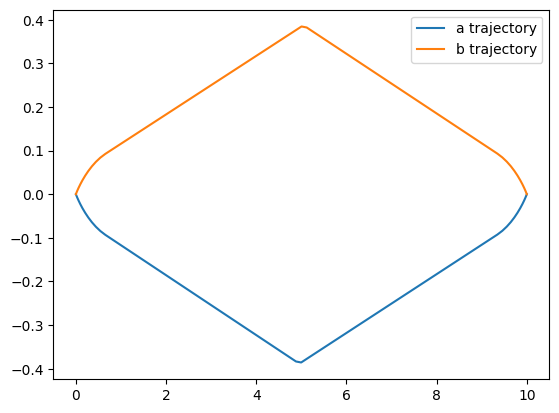

In [43]:
plt.plot(xa_out.value[:, 0], xa_out.value[:, 1], label='a trajectory')
plt.plot(xb_out.value[:, 0], xb_out.value[:, 1], label='b trajectory')
plt.legend()

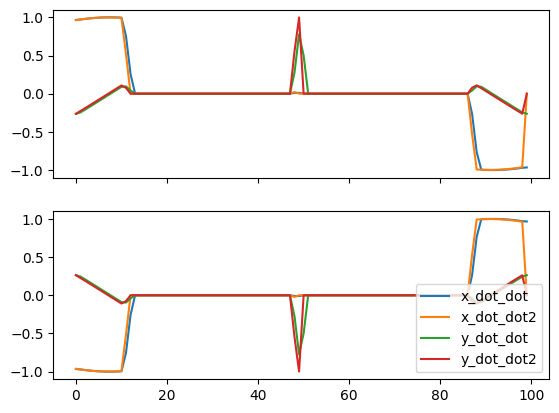

In [44]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(np.gradient(xa_out.value[:, 3], dt), label='x_dot_dot')
ax[0].plot(np.cos(xa_out.value[:, 2]) * ua_out.value[:, 0], label='x_dot_dot2')
ax[0].plot(np.gradient(xa_out.value[:, 4], dt), label='y_dot_dot')
ax[0].plot(np.sin(xa_out.value[:, 2]) * ua_out.value[:, 0], label='y_dot_dot2')
ax[1].plot(np.gradient(xb_out.value[:, 3], dt), label='x_dot_dot')
ax[1].plot(np.cos(xb_out.value[:, 2]) * ub_out.value[:, 0], label='x_dot_dot2')
ax[1].plot(np.gradient(xb_out.value[:, 4], dt), label='y_dot_dot')
ax[1].plot(np.sin(xb_out.value[:, 2]) * ub_out.value[:, 0], label='y_dot_dot2')
plt.legend()